In [1]:
import sys; sys.path.append('..')
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from model_torch.ldm.ddpm import LatentDiffusion

%load_ext autoreload
%autoreload 2

In [2]:
config = OmegaConf.load('../configs/ldm_simplified.yaml')
model = LatentDiffusion(**config.model).cuda()

Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Spatial Rescaler mapping from 29 to 3 channels after resizing.


In [3]:
import torch
unet_ckpt = torch.load('../ckpts/unet.ckpt')
vq_ckpt = torch.load('../ckpts/vq.ckpt')
rescaler_ckpt = torch.load('../ckpts/rescaler.ckpt')
model.first_stage_model.load_state_dict(vq_ckpt, strict=True)
model.cond_stage_model.load_state_dict(rescaler_ckpt, strict=True)
model.model.load_state_dict(unet_ckpt, strict=True)

<All keys matched successfully>

In [4]:
from PIL import Image
import os
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 as ToTensor
import numpy as np

name1 = '3477113127_aca40d90bb_b.jpg'
name2 = '16509884617_9aef0a5dd3_b.jpg'
SEG_PATH = '/nas/landscape/train_val/labels'
IMG_PATH = '/nas/landscape/train_val/images'
seg1 = Image.open(os.path.join(SEG_PATH, name1.replace('.jpg', '.png')))
img1 = Image.open(os.path.join(IMG_PATH, name1))
seg2 = Image.open(os.path.join(SEG_PATH, name2.replace('.jpg', '.png')))
img2 = Image.open(os.path.join(IMG_PATH, name2))
seg1 = np.array(seg1)
seg2 = np.array(seg2)
img1 = np.array(img1)
img2 = np.array(img2)
trans = A.Compose([
    A.Resize(384, 512),
    # A.RandomCrop(256, 256),
    ToTensor(),
])
img1, seg1 = trans(image=img1, mask=seg1).values()
img2, seg2 = trans(image=img2, mask=seg2).values()
seg1 = F.one_hot(seg1.long(), num_classes=29).permute(2, 0, 1)[None, ...].float()
seg2 = F.one_hot(seg2.long(), num_classes=29).permute(2, 0, 1)[None, ...].float()

In [5]:
print(img1.shape, seg1.shape)
seg_batch = torch.cat([seg1, seg2], dim=0).cuda()
print(seg_batch.shape)

torch.Size([3, 384, 512]) torch.Size([1, 29, 384, 512])
torch.Size([2, 29, 384, 512])


In [15]:
img, inter = model.sample(seg_batch, return_intermediates=True)

Sampling t: 100%|██████████| 1000/1000 [01:15<00:00, 13.27it/s]


In [16]:
img.shape

torch.Size([2, 3, 96, 128])

In [17]:
img_dec = model.decode_first_stage(img)
print(img_dec.shape)

torch.Size([2, 3, 384, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


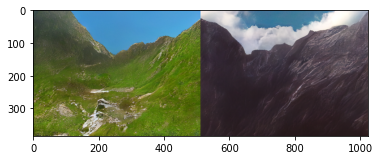

In [18]:
from utils import make_grid
grid = make_grid(img_dec.cpu().numpy(), 2)
plt.imshow((grid + 1) / 2)

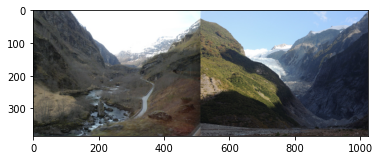

In [19]:
grid = make_grid(torch.cat((img1[None, ...], img2[None, Ellipsis]), dim=0).numpy(), 2)
plt.imshow(grid)